# Use case -  Oddball EEG ERP classification

This notebook is a very crude and straightforward demonstration of how one can prototype and configurate timeflux pipelines (graphs) offline, using recordings. 

Here, we work on EEG data acquired from [Unicorn headset](https://www.unicorn-bi.com/) during  an [Odddball paradigm](https://github.com/timeflux/timeflux_ui/blob/master/apps/oddball.yaml). In order to take advantage of mne very nice visualization tools, we'll be jumping from pandas DataFrame, and DataArray to mne objects. 

This notebook consists in: 
- loading the eeg signal and events from the hdf5 file
- jump in mne world to visualize the power spectral density (check for dead channels and line noise) 
- dejitter, filter and epoch the data using 
- eventually, jump again in mne world, by converting epochs into mne objects to visualize avergage ERPs
- cross-validate the classification of Standard versus Deviant with different pipelines

## Material
### EEG Device
- Setup:
    - unicorn headset:
        - dry or wet electrodes
        - channels: ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8']
    - photodiode
    
<img src="img/unicorn_headset.jpg" alt="headset" width="200"/>

### Oddball protocole

- Visual Oddball
    - 1200 stim
    - 167 deviants, 733 standards
    
```
$ git clone https://github.com/timeflux/timeflux_ui
$ conda activate timeflux
$ pip install git+https://github.com/timeflux/timeflux_ui
$ cd apps
$ timeflux oddball.yaml
```
and then, open http://localhost:8000/oddball/ 

<img src="img/oddball.gif" width="200"/>

In [1]:
# In notebook
import logging
logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.INFO)
from collections import OrderedDict
from glob import glob
import os 
import pathlib

import json
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import LogisticRegression, MDM
from pyriemann.estimation import ERPCovariances, XdawnCovariances
from pyriemann.utils.viz import plot_confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from timeflux.core.branch import Branch

from utils.utils import load_standalone_graph, pandas_to_mne, estimate_rate, uniform_sampling, get_scores


## Load data of a recording session

In [2]:
columns = ['Fp1', 'Fp2', 'C3', 'Cz', 'C4', 'O1', 'O2']
#columns = [f'EEG {k+1}' for k in range(8)]


In [3]:
fname = '/Users/raph/OMIND_SERVER/DATA/DATA_testing/oddball/flexicap/20200110-092940.hdf5' 

with pd.HDFStore(fname) as store:
    print(store.keys())
    eeg = pd.read_hdf(store, '/eeg')[columns]
    events = pd.read_hdf(store, '/events')
    meta = store.get_node('/eeg')._v_attrs['meta']

['/eeg', '/events']


In [4]:
# rename columns
names = meta.get('columns') 
if names is not None:
    eeg = eeg.rename(columns=names)
# dejitter signal 
rate = estimate_rate(eeg)
eeg = uniform_sampling(eeg, int(rate), interpolation_kind=None)

# deserialize events' data
events.data = events.data.apply( lambda d: json.loads(d) if isinstance(d, str) else d)
events.loc[events.label=='stim_on', 'data'] = events.loc[events.label=='stim_begins', 'data']

<img src="img/oddball.gif" width="200"/>

In [5]:
events.loc[events.label == 'stim_on', 'data'] = events[events.label == 'stim_begins'].data.values

In [6]:
events.head(15)

,label,data
2020-01-10 09:33:07.463510009,session_begins,NaN
2020-01-10 09:33:07.463885010,block_begins,NaN
2020-01-10 09:33:07.463989990,stim_begins,"{'on': 100, 'off': 1157, 'deviant': False}"
2020-01-10 09:33:07.499645020,stim_on,"{'on': 100, 'off': 1157, 'deviant': False}"
2020-01-10 09:33:07.606280029,stim_off,NaN
2020-01-10 09:33:08.765064941,stim_ends,NaN
2020-01-10 09:33:08.765159912,stim_begins,"{'on': 100, 'off': 1042, 'deviant': False}"
2020-01-10 09:33:08.773139893,stim_on,"{'on': 100, 'off': 1042, 'deviant': False}"
2020-01-10 09:33:08.889534912,stim_off,NaN
2020-01-10 09:33:09.932750000,stim_ends,NaN


## Convert pandas DataFrame to mne raw object 
Here, you go from pandas to mne format, only in order to take advantage of the visualizing tools. 
It should be notted that this conversion has nothing to do with timeflux online processing. 

In [7]:
raw, _, _ = pandas_to_mne(eeg); 
rate = raw.info['sfreq']
#filtered = raw.copy().filter(1, 30)
filtered = raw.copy().filter(1, 20, fir_design='firwin')
eeg_filtered = pd.DataFrame(filtered.to_data_frame().values, eeg.index, eeg.columns)

/Users/raph/miniconda3/envs/eeg_oddball_benchmark-env/lib/python3.7/site-packages/mne/utils/docs.py:830: DeprecationWarning: Function read_montage is deprecated; ``read_montage`` is deprecated and will be removed in v0.20. Please use ``read_dig_fif``, ``read_dig_egi``, ``read_custom_montage``, or ``read_dig_captrack`` to read a digitization based on your needs instead; or ``make_standard_montage`` to create ``DigMontage`` based on template; or ``make_dig_montage`` to create a ``DigMontage`` out of np.arrays
  warnings.warn(msg, category=DeprecationWarning)
/Users/raph/miniconda3/envs/eeg_oddball_benchmark-env/lib/python3.7/site-packages/mne/utils/docs.py:813: DeprecationWarning: Class Montage is deprecated; Montage class is deprecated and will be removed in v0.20. Please use DigMontage instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/raph/PycharmProject/backpack_notebooks/eeg_oddball_benchmark/utils/utils.py:204: DeprecationWarning: Setting a montage using anything rat

Converting "time" to "<class 'numpy.int64'>"...


<IPython.core.display.Javascript object>


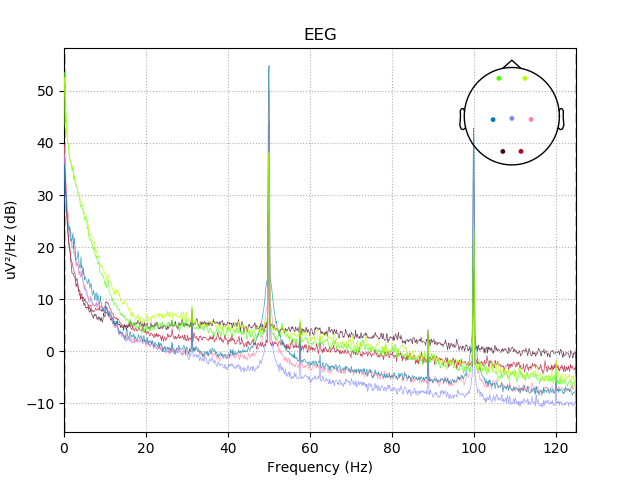

In [8]:
%matplotlib notebook 
raw.plot_psd(); 

<IPython.core.display.Javascript object>


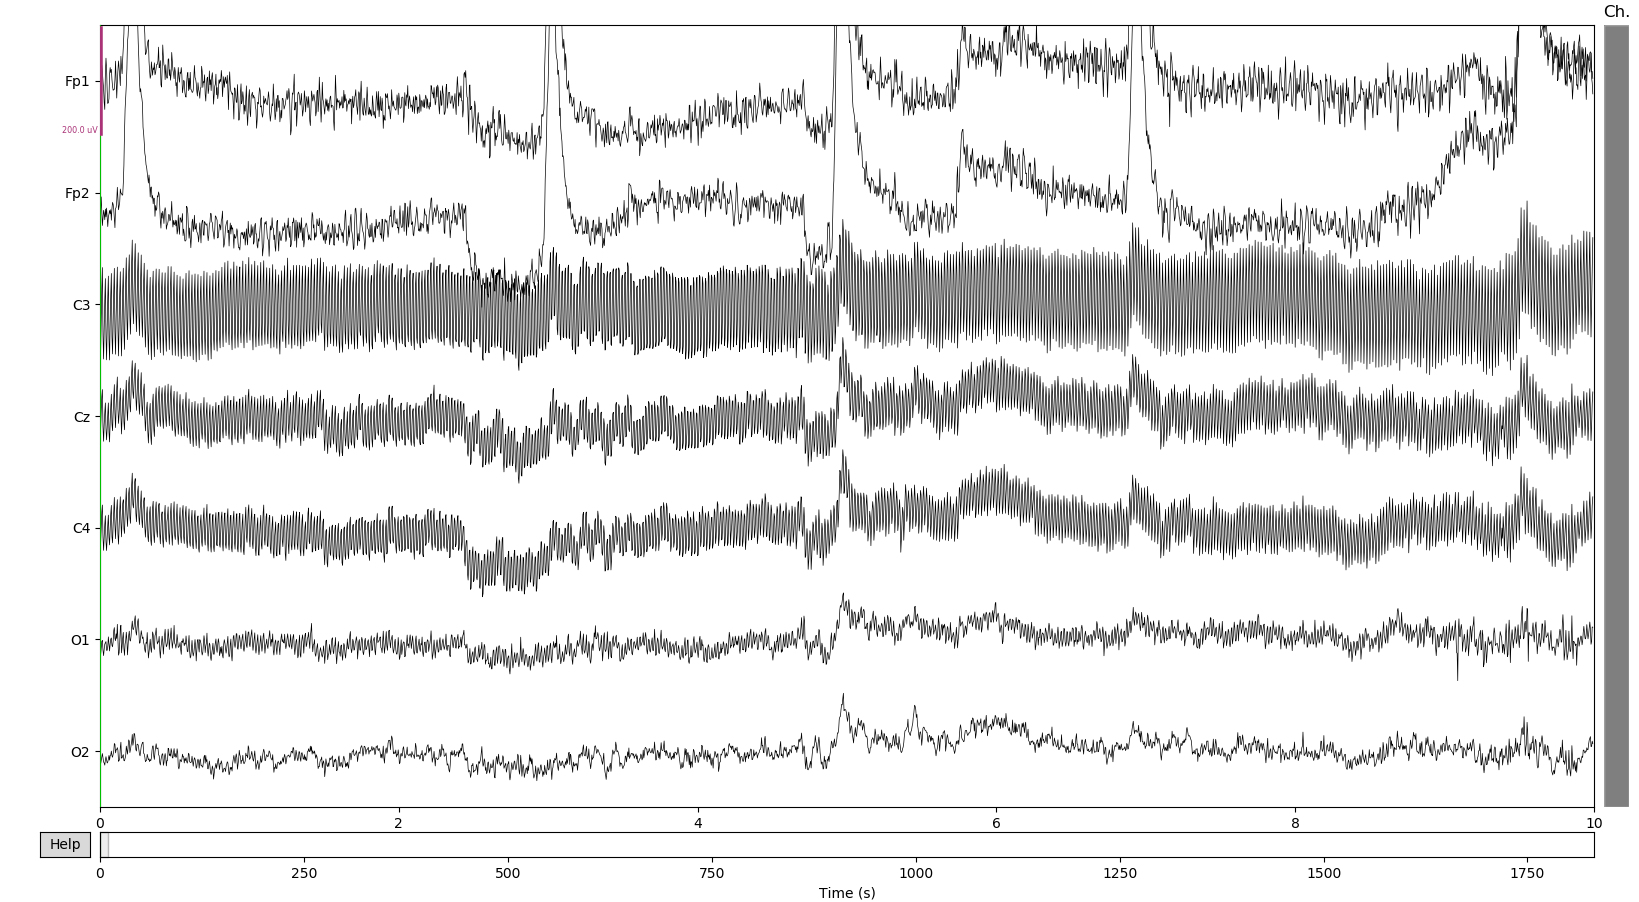

In [9]:
raw.plot(scalings=1e-4); 

## Epoching
### Load oddball graph and mimick the online loop

 - Epoch the data based on flash onsets
 - Convert multi ports epochs in XArray 
 - Convert XArray in mne Epoch using timeflux helpers

In [10]:
from timeflux.core.branch import Branch
graph = {
        'nodes': [
            {
                'id': 'epoch',
                'module': 'timeflux.nodes.epoch',
                'class': 'Epoch',
                'params': {
                    'before': .1,
                    'after': .5,
                    'event_trigger': 'stim_on'
                }
            },
            {
                'id': 'to_xarray',
                'module': 'timeflux.nodes.epoch',
                'class': 'ToXArray',
                'params': {
                    'reporting': 'warn'
                }
            }
        ],
        'edges': [
          
            {
                'source': 'epoch:*',
                'target': 'to_xarray'
            }

        ]
    }
epocher = Branch(graph)


epocher.set_port('epoch', port_id='i', data=eeg_filtered)
epocher.set_port('epoch', port_id='i_events', data=events)
epocher.update()
epochs_data = epocher.get_port('to_xarray').data
epochs_meta = epocher.get_port('to_xarray').meta
epochs_data.coords

Coordinates:
  * epoch    (epoch) int64 0 1 2 3 4 5 6 7 8 ... 742 743 744 745 746 747 748 749
  * time     (time) timedelta64[ns] -1 days +23:59:59.900000 ... 00:00:00.500000
  * space    (space) object 'Fp1' 'Fp2' 'C3' 'Cz' 'C4' 'O1' 'O2'

In [11]:
def bool_to_string(context):
    context['deviant'] = str(context['deviant'])
    return context
epochs_meta['epochs_context'] = list(map(bool_to_string, epochs_meta['epochs_context']))

## Eventually, use mne software to plot evoked traces 

In [12]:
from timeflux.helpers.mne import xarray_to_mne
epochs_mne = xarray_to_mne(epochs_data, epochs_meta, context_key='deviant', event_id={'True': 1, 'False': 0}, reporting='warn')
epochs_mne

<EpochsArray  |   750 events (all good), -0.100671 - 0.499329 sec, baseline off, ~6.0 MB, data loaded,
 'False': 606
 'True': 144>

<IPython.core.display.Javascript object>


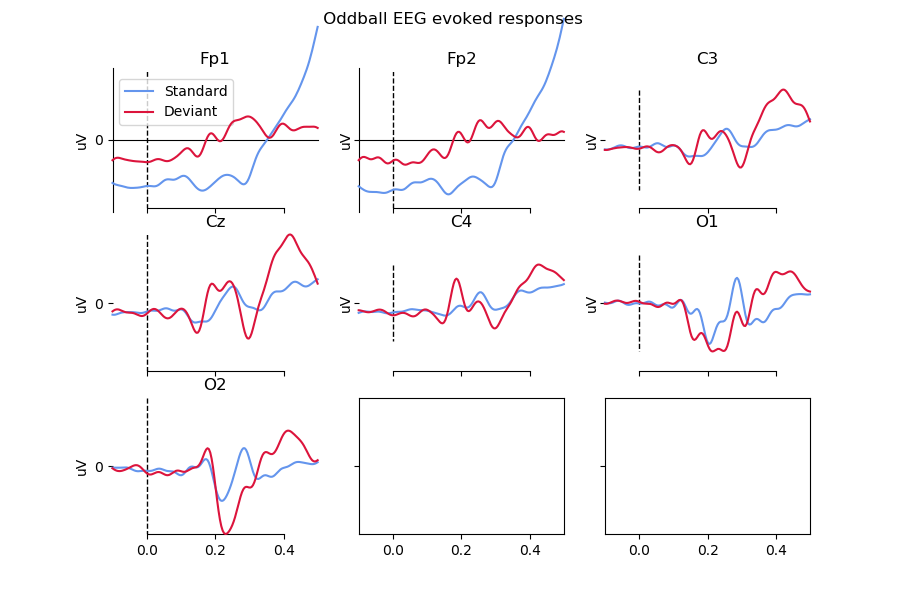

Text(0.5, 0.98, ' Oddball EEG evoked responses')

In [13]:
erp_list = list()
#condition = 'RT < 0.5'
conditions = ['False', 'True']
for condition in conditions:
    erp_list.append(epochs_mne[condition].average())
f, axes = plt.subplots(3, 3, figsize=(9, 6), sharex=True, sharey=True)
for k, ch in enumerate(eeg.columns):
    ax = f.axes[k]
    mne.viz.plot_compare_evokeds(erp_list, picks=ch,show_sensors=False, axes=ax,show=False, legend=False,
                     colors={"1":'CornFlowerBlue', '2':'Crimson'}); 
    ax.set_xlabel('')
    if k == 0:
        ax.legend(['Standard', 'Deviant'])
plt.suptitle((f' Oddball EEG evoked responses'), fontsize=12) 



# Plot the pipeline output classifications

We can plot the confusion matrix of the classification. 

In [14]:
from pyriemann.estimation import XdawnCovariances, Xdawn
from utils.pipelines import Vectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

clf_dict = OrderedDict()
clf_dict["ERPCovariance_MDM"] = make_pipeline(ERPCovariances(classes=[0, 1], estimator='oas', svd=None), MDM())
clf_dict["ERPCovariance_TS"] = make_pipeline(ERPCovariances(classes=[0, 1], estimator='oas', svd=None),TangentSpace(metric='riemann'), LogisticRegression(solver='lbfgs'))
clf_dict["XdawnCovariances_MDM"] = make_pipeline(XdawnCovariances(nfilter=3), MDM())
clf_dict["XdawnCovariances_TS"] = make_pipeline(XdawnCovariances(nfilter=3), TangentSpace(metric='riemann'),LogisticRegression(solver='lbfgs'))
clf_dict['Xdw + LDA'] = make_pipeline(Xdawn(nfilter=2, estimator='lwf'),
                                       Vectorizer(), LDA(solver='lsqr',
                                                         shrinkage='auto'))

#picks=['O1', 'O2', 'Oz',  'Fz', 'Cz', 'Pz',  'P3', 'FP1', 'CP1']
picks = list(set(epochs_mne.ch_names))
X = epochs_mne.get_data(picks=picks)
y = epochs_mne.events[:,-1]
L = []
cv = TimeSeriesSplit(n_splits=2)
for model in clf_dict.keys():
    clf = clf_dict[model]
    model_scores = get_scores(clf, X, y, cv=cv)
    model_scores['model'] = model
    L.append(model_scores)
scores = pd.concat(L, axis=0)
scores

,values,metrics,model
0,0.870027,AUC,ERPCovariance_MDM
1,0.893842,AUC,ERPCovariance_MDM
2,0.824,Accuracy,ERPCovariance_MDM
3,0.88,Accuracy,ERPCovariance_MDM
0,0.975068,AUC,ERPCovariance_TS
1,0.995726,AUC,ERPCovariance_TS
2,0.964,Accuracy,ERPCovariance_TS
3,0.956,Accuracy,ERPCovariance_TS
0,0.934851,AUC,XdawnCovariances_MDM
1,0.954351,AUC,XdawnCovariances_MDM


<IPython.core.display.Javascript object>


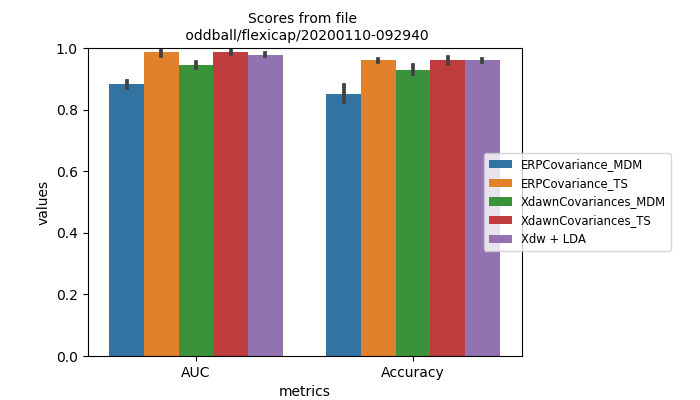

In [15]:
f, ax = plt.subplots(figsize=(7,4))
sns.barplot(data=scores, x='metrics', y='values',  hue='model', ax=ax)
ax.set_title(f"Scores from file \n {fname.split('testing/')[-1].split('.hdf5')[0]}", fontsize=10)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(.9, 0.5), fontsize='small')
plt.ylim([0,1]); 

<IPython.core.display.Javascript object>


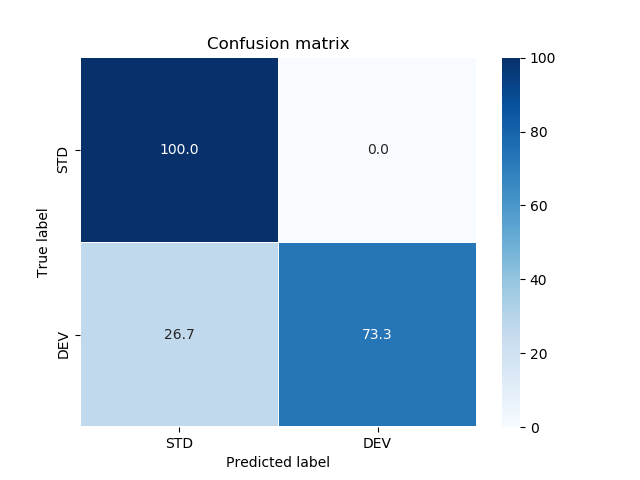

In [16]:

best_model = "ERPCovariance_TS" #scores[scores.metrics == 'AUC'].max().model
clf = clf_dict[best_model]
ntest = 200

clf.fit(X[:ntest,:,:], y[:ntest])
targets = y[-ntest:]
predictions = clf.predict(X[-ntest:,:,:])

plt.figure()
plot_confusion_matrix(targets, predictions, 
                      target_names=['STD', 'DEV'], 
                      title='Confusion matrix', 
                      cmap='Blues')
plt.ylim([2, 0]); 
plt.show()

In [17]:
scores = []
ntrains = [10, 50, 100, 150, 200, 300, 400, 500, 600, 700, 800]
ntest = 100
for ntrain in ntrains: 
    clf.fit(X[:ntrain,:,:], y[:ntrain])
    targets = y[-ntest:]
    predictions = clf.predict(X[-ntest:,:,:])
    auc_roc = roc_auc_score(targets, predictions)
    scores.append(auc_roc)

<IPython.core.display.Javascript object>


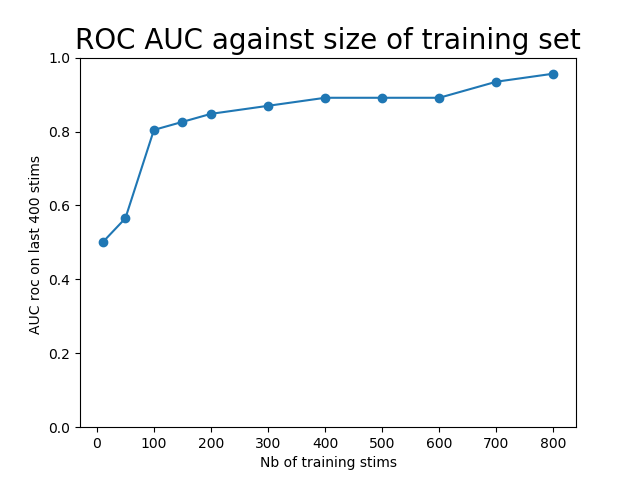

Text(0.5, 1.0, 'ROC AUC against size of training set')

In [18]:
device = fname.split('/')[-2]
acquisition = fname.split('/')[-1].replace('.hdf5', '')
plt.figure()
plt.plot(ntrains, scores, '-o')
plt.xlabel('Nb of training stims', fontsize=10)
plt.ylabel('AUC roc on last 400 stims ',  fontsize=10)
plt.ylim([0,1]);
plt.title('ROC AUC against size of training set', fontsize=20)
